In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.utils import resample, shuffle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns  
import random  
from tqdm import tqdm


In [2]:
# ========================
# STEP 1: Load Preprocessed Spike Data
# ========================

# These CSV files contain neural activity during different time periods
df_fix = pd.read_csv("spike_fixation.csv")  # spikes during fixation period
df_onset = pd.read_csv("spikes_onset.csv")  # spikes during image onset period
print("Fixation data shape:", df_fix.shape)
print("Onset data shape:", df_onset.shape)
print("Fixation columns:", df_fix.columns.tolist())
print("Onset columns:", df_onset.columns.tolist())

Fixation data shape: (1149625, 16)
Onset data shape: (1149625, 18)
Fixation columns: ['New Neuron ID', 'Subject ID', 'Session', 'Neuron ID', 'Neuron Area', 'Trial ID', 'Start Time', 'End Time', 'Spike Counts', 'Firing Rate', 'Absolute Spikes (μs)', 'Trial-Aligned Spikes (μs)', 'Trial-Aligned Spikes (ms)', 'Image ID', 'Identity', 'Recognition']
Onset columns: ['New Neuron ID', 'Subject ID', 'Session', 'Neuron ID', 'Neuron Area', 'Trial ID', 'Start Time', 'End Time', 'Spike Counts', 'Firing Rate', 'Image ID', 'Identity', 'Recognition', 'Gender', 'Trial-Aligned Spikes (μs)', 'Trial-Aligned Spikes (ms)', 'Normalized FR', 'Baselined FR']


In [3]:
# ========================
# STEP 2: Parse Spike Trains
# ========================

# Spike times are stored as strings like "[1234, 5678, ...]"
# We'll convert them to numpy arrays and scale from microseconds to seconds
def parse_spikes(spike_str):
    try:
        return np.array(ast.literal_eval(spike_str)) / 1e6  # convert to seconds
    except:
        return np.array([])  # if it fails, return empty spike train

# Apply the parsing function to both datasets
df_fix["Spike Times (s)"] = df_fix["Trial-Aligned Spikes (μs)"].apply(parse_spikes)
df_onset["Spike Times (s)"] = df_onset["Trial-Aligned Spikes (μs)"].apply(parse_spikes)

print("Example parsed spike train (onset):", df_onset["Spike Times (s)"].iloc[0])
print("Length of spike train:", len(df_onset["Spike Times (s)"].iloc[0]))

# See how many spike trains are non-empty
# Function to check if spike train is non-empty
def has_spikes(spike_array):
    return len(spike_array) > 0

# Filter non-empty spike trains (onset)
mask_onset = df_onset["Spike Times (s)"].apply(has_spikes)
nonempty_onset = df_onset[mask_onset]

# Print one example spike train from onset
if not nonempty_onset.empty:
    print("Example parsed spike train (onset, non-empty):")
    print(nonempty_onset["Spike Times (s)"].iloc[0])
else:
    print("No non-empty spike trains found in onset!")

# Count non-empty spike trains in fixation
mask_fix = df_fix["Spike Times (s)"].apply(has_spikes)
nonempty_fix_count = mask_fix.sum()
print(f"Non-empty spike trains in fixation: {nonempty_fix_count} / {len(df_fix)}")


Example parsed spike train (onset): []
Length of spike train: 0
Example parsed spike train (onset, non-empty):
[0.063235   0.07414125 0.07976625 0.1672975  0.17301625]
Non-empty spike trains in fixation: 368188 / 1149625


In [4]:
# ========================
# STEP 3: Compute Baseline Statistics (Mean + Std)
# ========================

# We'll use the fixation period to calculate a baseline firing rate for each neuron
baseline_stats = (
    df_fix.groupby("Neuron ID")["Firing Rate"]
    .agg(["mean", "std"])  # compute mean and standard deviation
    .rename(columns={"mean": "Baseline Mean", "std": "Baseline STD"})
)
print("Baseline stats preview:")
print(baseline_stats.head())

print("Neurons with missing baseline:", baseline_stats.isna().sum().sum())


Baseline stats preview:
           Baseline Mean  Baseline STD
Neuron ID                             
0               0.349091      1.155469
1               0.054545      0.405705
2               4.803636      4.484499
3               0.065455      0.394968
4               1.687273      2.808461
Neurons with missing baseline: 0


In [5]:
# ========================
# STEP 4: Filter Out Low-Firing Neurons
# ========================

# We'll remove neurons that fire less than 0.15 Hz on average
# First, compute the mean firing rate for each neuron
mean_fr_per_neuron = df_onset.groupby("Neuron ID")["Firing Rate"].mean()

# Find neurons that meet the minimum threshold
valid_neurons = mean_fr_per_neuron[mean_fr_per_neuron >= 0.15].index.tolist()

# Find neurons that will be removed
all_neurons = mean_fr_per_neuron.index.tolist()
removed_neurons = list(set(all_neurons) - set(valid_neurons))

# Print summary
print(f"Neurons kept: {len(valid_neurons)}")
print(f"Neurons removed (firing rate < 0.15 Hz): {len(removed_neurons)}")

# Optional: print IDs of removed neurons
# print("Removed neuron IDs:", removed_neurons)

# Now filter the datasets to include only valid neurons
df_onset = df_onset[df_onset["Neuron ID"].isin(valid_neurons)]
df_fix = df_fix[df_fix["Neuron ID"].isin(valid_neurons)]


Neurons kept: 1594
Neurons removed (firing rate < 0.15 Hz): 488


In [6]:
# ========================
# STEP 5: Balance Trial Counts Across Subjects
# ========================

# Create a unique trial identifier: (Subject ID, Session, Trial ID)
df_onset["Trial Key"] = list(zip(df_onset["Subject ID"], df_onset["Session"], df_onset["Trial ID"]))

# Count how many unique trials each subject contributed
trial_keys_per_subject = df_onset.groupby("Subject ID")["Trial Key"].nunique()
min_trials = trial_keys_per_subject.min()
print(f"Balancing to {min_trials} trials per subject")

# Sample equal number of trials from each subject
balanced_trial_keys = []

for subject_id in df_onset["Subject ID"].unique():
    subject_df = df_onset[df_onset["Subject ID"] == subject_id]
    unique_keys = subject_df["Trial Key"].drop_duplicates().tolist()

    # Randomly sample trials for balance
    sampled_keys = random.sample(unique_keys, k=min_trials)
    balanced_trial_keys.extend(sampled_keys)

# Keep only the balanced trials
df_onset_balanced = df_onset[df_onset["Trial Key"].isin(balanced_trial_keys)]

# Drop the helper column if no longer needed
df_onset_balanced = df_onset_balanced.drop(columns=["Trial Key"])

# Show summary
print(f"Total balanced trials (all subjects): {len(balanced_trial_keys)}")
print(f"Shape after balancing: {df_onset_balanced.shape}")

Balancing to 550 trials per subject
Total balanced trials (all subjects): 6600
Shape after balancing: (241686, 19)


In [7]:
# ========================
# STEP 6: Define Binning Parameters
# ========================

# Each bin is 250 ms wide, and we move the window every 100 ms
bin_size = 0.25  # 250 ms
step_size = 0.1  # 100 ms
time_bins = np.arange(0, 1.0 - bin_size + step_size, step_size)

In [8]:
# ========================
# STEP 7: Build the 3D Spike Matrix
# ========================

# Build 3D matrix: trials × neurons × time bins
neuron_ids = sorted(df_onset_balanced["Neuron ID"].unique())
df_onset_balanced["Trial Key"] = list(zip(df_onset_balanced["Subject ID"], df_onset_balanced["Session"], df_onset_balanced["Trial ID"]))
trial_keys = sorted(df_onset_balanced["Trial Key"].unique())

binned_matrix = np.zeros((len(trial_keys), len(neuron_ids), len(time_bins)))

neuron_idx_map = {nid: i for i, nid in enumerate(neuron_ids)}
trial_idx_map = {key: i for i, key in enumerate(trial_keys)}

# Fill the matrix
for _, row in df_onset_balanced.iterrows():
    trial_key = (row["Subject ID"], row["Session"], row["Trial ID"])
    neuron_id = row["Neuron ID"]
    spikes = row["Spike Times (s)"]

    if neuron_id not in baseline_stats.index:
        continue

    baseline_mean = baseline_stats.loc[neuron_id, "Baseline Mean"]
    baseline_std = baseline_stats.loc[neuron_id, "Baseline STD"]
    baseline_std = baseline_std if baseline_std != 0 else 1.0

    spike_counts = np.array([
        np.sum((spikes >= t) & (spikes < t + bin_size)) for t in time_bins
    ])

    firing_rates = spike_counts / bin_size
    zscored = (firing_rates - baseline_mean) / baseline_std

    trial_idx = trial_idx_map[trial_key]
    neuron_idx = neuron_idx_map[neuron_id]
    binned_matrix[trial_idx, neuron_idx, :] = zscored

In [9]:
# ========================
# STEP 8: Create Gender Labels
# ========================

# First make sure Trial Key is still in df_onset_balanced
df_onset_balanced["Trial Key"] = list(zip(df_onset_balanced["Subject ID"], df_onset_balanced["Session"], df_onset_balanced["Trial ID"]))

# Build a mapping from Trial Key → Gender
trial_gender_map = (
    df_onset_balanced[["Trial Key", "Gender"]]
    .drop_duplicates("Trial Key")
    .set_index("Trial Key")["Gender"]
    .to_dict()
)

# Build label vector y to match trial_keys used in the 3D matrix
y = np.array([0 if trial_gender_map[key] == 'F' else 1 for key in trial_keys])

print("Gender label counts (0=F, 1=M):", np.bincount(y))
print("Shape of y:", y.shape)
print("Shape of binned_matrix:", binned_matrix.shape)

Gender label counts (0=F, 1=M): [2338 4262]
Shape of y: (6600,)
Shape of binned_matrix: (6600, 1594, 9)


In [10]:
# ========================
# STEP 9: Flatten Matrix for Machine Learning
# ========================

# Collapse the 3D matrix into 2D: (trials, neurons × bins)
X = binned_matrix.reshape(len(trial_keys), -1)

# Print basic info
print(f"Collapsed matrix shape: {X.shape}")
print(f"Label shape: {y.shape}")
print(f"Class balance: {np.bincount(y)}")

Collapsed matrix shape: (6600, 14346)
Label shape: (6600,)
Class balance: [2338 4262]


In [11]:
# ========================
# STEP 10: Balance Classes via Bootstrapping
# ========================

# Split data into female (0) and male (1)
X_0 = X[y == 0]
X_1 = X[y == 1]
n_0 = len(X_0)
n_1 = len(X_1)

# Upsample the smaller class to match the larger one
if n_0 < n_1:
    X_0_up = resample(X_0, replace=True, n_samples=n_1, random_state=42)
    y_0_up = np.zeros(n_1, dtype=int)
    X_balanced = np.vstack((X_0_up, X_1))
    y_balanced = np.hstack((y_0_up, np.ones(n_1, dtype=int)))

elif n_1 < n_0:
    X_1_up = resample(X_1, replace=True, n_samples=n_0, random_state=42)
    y_1_up = np.ones(n_0, dtype=int)
    X_balanced = np.vstack((X_1_up, X_0))
    y_balanced = np.hstack((y_1_up, np.zeros(n_0, dtype=int)))

else:
    # If classes are already balanced
    X_balanced = np.vstack((X_0, X_1))
    y_balanced = np.hstack((np.zeros(n_0, dtype=int), np.ones(n_1, dtype=int)))

# Shuffle the dataset to mix class order
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# Final check
print("Final class counts:", np.bincount(y_balanced))
print("Final matrix shape:", X_balanced.shape)

Final class counts: [4262 4262]
Final matrix shape: (8524, 14346)


In [12]:
# ========================
# STEP 11: Final Dataset Summary
# ========================

# This is a quick check to understand what our final dataset looks like

# Print the shape of the feature matrix
# This tells us how many trials we have, and how many features (neurons × bins) per trial
print("Shape of X_balanced (trials, features):", X_balanced.shape)

# Count how many samples we have from each class (0 = Female, 1 = Male)
# This should be balanced thanks to the upsampling step
print("Class label counts (0 = F, 1 = M):", np.bincount(y_balanced))

# Show the range of values in the features (should be z-scored)
# Useful to verify everything looks reasonable before training a model
print("Feature range: min =", X_balanced.min(), "max =", X_balanced.max())

# Print the overall mean and standard deviation of the features
# Z-scoring usually centers features around 0 with std ~1
print("Feature mean and std:", round(X_balanced.mean(), 4), round(X_balanced.std(), 4))


Shape of X_balanced (trials, features): (8524, 14346)
Class label counts (0 = F, 1 = M): [4262 4262]
Feature range: min = -3.9011781437676203 max = 82.87155360808164
Feature mean and std: -0.0002 0.2068


In [13]:
# ========================
# STEP 12: Convert Matrix to DataFrame for Easy Viewing
# ========================

import pandas as pd

# Create generic feature names like f0, f1, f2, ..., fN
# These represent neuron-timebin features
num_features = X_balanced.shape[1]  # total number of features
column_names = [f"f{i}" for i in range(num_features)]  # name each column "f0", "f1", etc.

# Create a DataFrame from the balanced feature matrix
# This makes it easier to inspect the data
df_view = pd.DataFrame(X_balanced, columns=column_names)

# Add a column for gender label (0 = Female, 1 = Male)
# This helps with filtering, plotting, or grouping by gender
df_view["Label"] = y_balanced

# View the first few rows of the table (by default shows 5 rows)
print("Preview of final feature table:")
df_view.head()

Preview of final feature table:


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f14337,f14338,f14339,f14340,f14341,f14342,f14343,f14344,f14345,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
zero_rows = np.sum(X_balanced == 0, axis=1)
print("Fully zero feature rows:", np.sum(zero_rows == X_balanced.shape[1]))

Fully zero feature rows: 0


In [ ]:
# ========================
# STEP 13: Gender Decoding with SVM (Safe Serial Version)
# ========================

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import sys

# Number of decoding repetitions
n_runs = 100

# === Your input data (already defined) ===
# X_balanced: shape (samples, features)
# y_balanced: shape (samples,)
# Ensure these are preloaded before running!

def run_single_decoding(i):
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced,
        test_size=0.3,
        stratify=y_balanced,
        random_state=i
    )

    clf = SVC(kernel="linear", class_weight="balanced", random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100  # percent accuracy

    return acc, (y_test, y_pred) if i == n_runs - 1 else None

# === SERIAL version for debugging (no joblib)
print("Starting decoding (serial)...")
results = [run_single_decoding(i) for i in tqdm(range(n_runs), desc="Running SVM Decoding")]
print("Decoding finished. Extracting results...")

# === Extract results
accuracies = []
last_result = None

for acc, preds in results:
    accuracies.append(acc)
    if preds is not None:
        last_result = preds

if last_result is None:
    raise RuntimeError("Final predictions not found!")
else:
    last_y_test, last_y_pred = last_result
    print("Final predictions extracted.")

# === Optional summary
print(f"Mean Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")
print("All done.")



Running SVM Decoding: 100%|██████████| 100/100 [2:21:00<00:00, 84.61s/it] 


Confusion Matrix (Last Run):
                   Predicted Female  Predicted Male
Actual Female (0)              1067             212
Actual Male (1)                 621             658


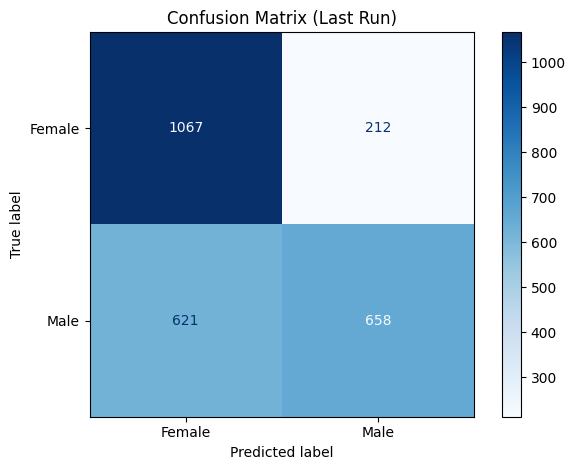

In [16]:
# ========================
# STEP 14: Confusion Matrix from Last Run
# ========================

# Calculate confusion matrix from last decoding run
cm = confusion_matrix(last_y_test, last_y_pred)

# Display confusion matrix as a table
print("Confusion Matrix (Last Run):")
print(pd.DataFrame(cm,
                   index=["Actual Female (0)", "Actual Male (1)"],
                   columns=["Predicted Female", "Predicted Male"]))

# Plot the matrix using sklearn's display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Last Run)")
plt.tight_layout()
plt.show()

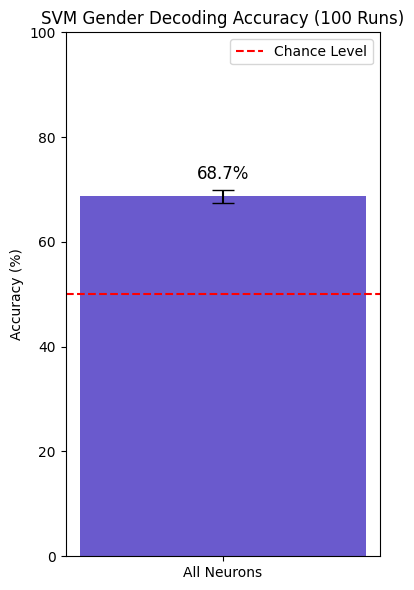

In [17]:
# ========================
# STEP 15: Accuracy Summary
# ========================

# Compute mean and standard deviation of accuracy across runs
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

# Plot mean accuracy with error bars
plt.figure(figsize=(4, 6))
plt.bar(["All Neurons"], [mean_acc], yerr=[std_acc], color='slateblue', capsize=8)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.axhline(50, color='red', linestyle='--', label="Chance Level")
plt.title(f"SVM Gender Decoding Accuracy ({n_runs} Runs)")
plt.text(0, mean_acc + std_acc + 2, f"{mean_acc:.1f}%", ha='center', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# ========================
# STEP 16: Final Summary Output
# ========================
print("Final Decoding Summary:")
print(f"Mean Accuracy over {n_runs} runs: {mean_acc:.2f}% ± {std_acc:.2f}")

Final Decoding Summary:
Mean Accuracy over 100 runs: 68.72% ± 1.22


In [ ]:
# ========================
# STEP 17: Null Distribution Test (Safe Serial Version)
# ========================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import sys

# --------------------------------------------
# Step 1: Real accuracy (from decoder summary)
# --------------------------------------------
real_accuracy = mean_acc / 100  # e.g. 0.713
print(f"Real decoder accuracy: {real_accuracy:.3f}")
sys.stdout.flush()

# --------------------------------------------
# Step 2: Null decoding runs (serial for now)
# --------------------------------------------
n_shuffles = 100

def run_null_decoding(i, X, y):
    y_shuffled = np.random.permutation(y)

    # Skip invalid shuffles (e.g., only 1 class)
    if len(np.unique(y_shuffled)) < 2:
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_shuffled, test_size=0.3, stratify=y_shuffled, random_state=i
    )

    clf = SVC(kernel="linear", class_weight="balanced", max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    return acc

# === SERIAL: Safe version
print("Starting null decoding (serial)...")
shuffle_results = [run_null_decoding(i, X_balanced, y_balanced) for i in tqdm(range(n_shuffles), desc="Running Null Decoders")]
print("Null decoders complete.")
sys.stdout.flush()

# --------------------------------------------
# Step 3: Calculate empirical p-value
# --------------------------------------------
shuffle_mean_accuracies = np.array([acc for acc in shuffle_results if acc is not None])
p_value = (np.sum(shuffle_mean_accuracies >= real_accuracy) + 1) / (n_shuffles + 1)

# --------------------------------------------
# Step 4: Plot results
# --------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(shuffle_mean_accuracies, bins=30, alpha=0.7, label="Null Distribution (Mean Acc)")
plt.axvline(real_accuracy, color="red", linestyle="--", linewidth=2,
            label=f"Real Mean Accuracy ({real_accuracy*100:.2f}%)")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.title("Null Distribution of Decoding Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------
# Step 5: Print Summary
# --------------------------------------------
print("\nNull distribution test summary")
print(f"Mean shuffled accuracy: {shuffle_mean_accuracies.mean():.3f}")
print(f"Real decoder accuracy: {real_accuracy:.3f}")
print(f"Empirical p-value: {p_value:.5f}")

# Optional: 95% confidence interval for null
ci_lower = np.percentile(shuffle_mean_accuracies, 2.5)
ci_upper = np.percentile(shuffle_mean_accuracies, 97.5)
print(f"Null distribution 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


Real decoder accuracy: 0.687


Running Null Decoders:   0%|          | 0/100 [00:00<?, ?it/s]/home/nuttidalab/anaconda3/envs/cog_flex/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nuttidalab/anaconda3/envs/cog_flex/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nuttidalab/anaconda3/envs/cog_flex/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nuttidalab/anaconda3/envs/cog_flex/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

KeyboardInterrupt: 